In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from pathlib import Path
import math
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

In [2]:

def find_word_Common(sample):
    """finding number of words common in both user question and archived Question"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" ")))    
    return len(uq & aq)*1.0

def find_total_word_count(sample):
    """Finding total number of words in both user and archived questions"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" ")))   
    return (len(uq) + len(aq))*1.0
#test_ml['total_word_count'] = test_ml.apply(find_total_word_count, axis=1)

def fraction_common_words(sample):
    """Finding the ratio of the number of words in common and total number of words in user and archived questions"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" "))) 
    return 1.0 * len(uq & aq)/(len(uq) + len(aq))
#test_ml['fraction_common_words'] = test_ml.apply(fraction_common_words, axis=1)

# Machine Learning Method1: Probabilistic classifier+Basic Features+Word2vec for distance feature

In [3]:
QApair_df = pd.read_csv('train.csv')
QApair_df = shuffle(QApair_df)
QApair_df = QApair_df.dropna() #dropping na
QApair_df[:2]

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
5289,2571,41704,513994,if i buy a domain do i need to buy all the oth...,513995,where can i buy a ly domain,204821,NIC.LY - Libya ccTLD...Is the registrar.,0,1,0,1,1,72,31,18,9,5.0,24.0,0.208333
259,1101,91543,60269,what is genre,60270,what is a genre,23361,Oh that would have to be Trad Jazz. I've never...,1,1,1,1,2,15,17,4,5,4.0,9.0,0.444444


In [4]:
all_text = QApair_df[["qu","qa"]]
all_labels = QApair_df["is_duplicate"]
print("all text size", len(all_text))
print("All label size", len(all_labels))


all text size 8000
All label size 8000


In [5]:
all_user_text = all_text["qu"].tolist() #
all_arch_text = all_text["qa"].tolist()

In [6]:
path_of_downloaded_bin = Path("C:\\Users\\ASUS\\NLP\\embeddings\\GoogleNews-vectors-negative300.bin")
word_vectors = KeyedVectors.load_word2vec_format(datapath(path_of_downloaded_bin), binary=True)

In [7]:
word_vec_dim = 300 # this number should match the embedding used
oov_vec = np.random.rand(word_vec_dim) 
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in word_tokenize(sent):
        if token not in word_vectors: 
            word_vecs.append(oov_vec)
        else:
            word_vecs.append(word_vectors[token].astype('float64'))
    return (np.mean(word_vecs,axis=0)).reshape(1,-1)


In [8]:
#following embeddingds are used for finding diff distances between question pairs of all vectors
all_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_user_text]) #getting vector representation for user questions
all_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_arch_text]) #getting vector representation for archived questions


In [9]:
#getting distnces
cosine_dist = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
euclid_dis = [euclidean_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)]
manhat_dis = [manhattan_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)]


In [10]:
QApair_df['cosine_dist'] = cosine_dist
QApair_df['euclid_dis'] = euclid_dis
QApair_df['manhat_dis'] = manhat_dis


In [11]:
QApair_df[:2]

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,...,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words,cosine_dist,euclid_dis,manhat_dis
5289,2571,41704,513994,if i buy a domain do i need to buy all the oth...,513995,where can i buy a ly domain,204821,NIC.LY - Libya ccTLD...Is the registrar.,0,1,...,72,31,18,9,5.0,24.0,0.208333,0.063511,0.674567,9.385409
259,1101,91543,60269,what is genre,60270,what is a genre,23361,Oh that would have to be Trad Jazz. I've never...,1,1,...,15,17,4,5,4.0,9.0,0.444444,0.583476,2.564767,38.356850


In [12]:
#checking if all columns are present including the columns for all newly create distance features
QApair_df.columns

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words', 'cosine_dist',
       'euclid_dis', 'manhat_dis'],
      dtype='object')

In [13]:
x_data = QApair_df[['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_dist', 'euclid_dis','manhat_dis']].copy()
y_data = QApair_df['is_duplicate'].copy()

# Logistic regression+ Basic Features+Word2vec for distance feature

In [14]:
#model using best params from grid search
clf = LogisticRegression(C = 10,class_weight = 'dict', max_iter = 1000, solver = 'lbfgs').fit(x_data, y_data)

Feature:  l_uq , Score: -0.00451
Feature:  l_aq , Score: 0.01252
Feature:  num_words_uq , Score: -0.07717
Feature:  num_words_aq , Score: -0.14405
Feature:  n_common_words , Score: 0.31025
Feature:  cosine_dist , Score: 0.10618
Feature:  euclid_dis , Score: -8.24731
Feature:  manhat_dis , Score: 0.53726


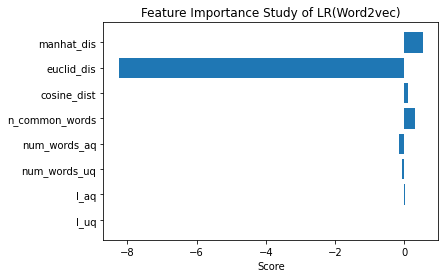

In [15]:
#get feature importance plot
feature_list = ['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_dist', 'euclid_dis','manhat_dis']
importance = clf.coef_[0]
for i,v in zip(feature_list,importance):
    print('Feature: ',i, ', Score: %.5f' % v)
# plot feature importance
plt.barh(feature_list, importance)
plt.xlabel("Score")
plt.title("Feature Importance Study of LR(Word2vec)")
plt.show()

In [16]:
#finding mean reciprocal rank:
test_df_ml = pd.read_csv('test.csv') #getting the test data
test_df_ml.columns

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words'],
      dtype='object')

In [17]:
test_df_ml = test_df_ml[['guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
test_df_ml = test_df_ml[:500]
l = len(test_df_ml['qa'])#Number of archived Questions
print("Number of archived Questions:",l)

Number of archived Questions: 500


In [18]:
user_questions = test_df_ml['qu'].tolist()
LR_WV_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l #appending user question to all archived questions dataframe
    test_ml['l_uq'] = test_ml['qu'].str.len()
    test_ml['l_aq'] = test_ml['qa'].str.len()
    test_ml['num_words_uq'] = test_ml['qu'].apply(lambda x: len(x.split(" ")))
    test_ml['num_words_aq'] = test_ml['qa'].apply(lambda x: len(x.split(" ")))
    test_ml['n_common_words'] = test_ml.apply(find_word_Common, axis=1)
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_dist'] = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_ml['euclid_dis']  = [euclidean_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_ml['manhat_dis'] = [manhattan_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_x_data = test_ml[['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_dist', 'euclid_dis','manhat_dis']].copy()
    test_x_data = test_x_data.values
    y_pred = clf.predict_proba(test_x_data) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        LR_WV_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        LR_WV_reciprocal_rank_list.append(0)
       


In [19]:
LR_WV_mean_reciprocal_rank = np.mean(np.array(LR_WV_reciprocal_rank_list))
print("Mean Reciprocal Rank for Logistic regression+Basic features+Word2vec ",LR_WV_mean_reciprocal_rank)
print("Number of question correctly retreived for Logistic regression+Basic features+Word2Vec ", sum(LR_WV_reciprocal_rank_list) )

Mean Reciprocal Rank for Logistic regression+Basic features+Word2vec  0.77
Number of question correctly retreived for Logistic regression+Basic features+Word2Vec  385


# Naive base+Basic Features+ Word2Vec for distance Feature

In [20]:
#fitting with best params
nb = MultinomialNB(alpha = 100.0).fit(x_data,y_data)

Feature:  l_uq , Score: -1.02613
Feature:  l_aq , Score: -1.03259
Feature:  num_words_uq , Score: -2.61043
Feature:  num_words_aq , Score: -2.61667
Feature:  n_common_words , Score: -3.11159
Feature:  cosine_sim , Score: -6.56527
Feature:  euclid_dis , Score: -5.08043
Feature:  manhat_dis , Score: -2.44389


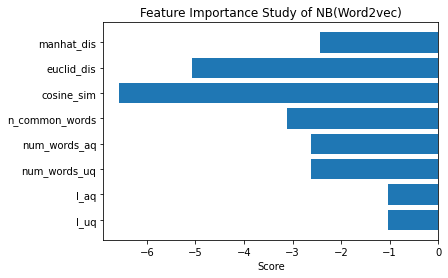

In [21]:
#get feature importance plot
feature_list = ['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_sim', 'euclid_dis','manhat_dis']
importance = nb.coef_[0]
for i,v in zip(feature_list,importance):
    print('Feature: ',i, ', Score: %.5f' % v)
# plot feature importance
plt.barh(feature_list, importance)
plt.xlabel("Score")
plt.title("Feature Importance Study of NB(Word2vec)")
plt.show()

In [22]:
user_questions = test_df_ml['qu'].tolist()
NB_WV_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l
    test_ml['l_uq'] = test_ml['qu'].str.len()
    test_ml['l_aq'] = test_ml['qa'].str.len()
    test_ml['num_words_uq'] = test_ml['qu'].apply(lambda x: len(x.split(" ")))
    test_ml['num_words_aq'] = test_ml['qa'].apply(lambda x: len(x.split(" ")))
    test_ml['n_common_words'] = test_ml.apply(find_word_Common, axis=1)
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_sim'] = [cosine_similarity(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_ml['euclid_dis']  = [euclidean_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_ml['manhat_dis'] = [manhattan_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_x_data = test_ml[['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_sim', 'euclid_dis','manhat_dis']].copy()
    test_x_data = test_x_data.values
    y_pred = nb.predict_proba(test_x_data) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        NB_WV_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        NB_WV_reciprocal_rank_list.append(0)


In [23]:
NB_WV__mean_reciprocal_rank = np.mean(np.array(NB_WV_reciprocal_rank_list))
print("Mean Reciprocal Rank for Naivebase+Basic features_Word2Vec ",NB_WV__mean_reciprocal_rank)
print("Number of question correctly retreived for Naivebase+Basic features_Word2Vec: ", sum(NB_WV_reciprocal_rank_list))

Mean Reciprocal Rank for Naivebase+Basic features_Word2Vec  0.692
Number of question correctly retreived for Naivebase+Basic features_Word2Vec:  346


# Machine Learning Method1: Probabilistic classifier+Basic Features+Glove for distance feature

In [24]:
QApair_df = pd.read_csv('train.csv')
QApair_df = shuffle(QApair_df)
QApair_df = QApair_df.dropna() #dropping na
QApair_df[:2]

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
2714,10974,126029,131721,why do people have so much trust in their rela...,143367,why do we lose the trust on the people after a...,151533,We??Who we?You are we here or we are we?See br...,1,1,1,1,2,137,62,28,14,8.0,38.0,0.210526
7093,6273,221759,294461,what makes the fundamental theorem of calculus...,294462,why is there a variable usually x in the secon...,85779,"No, it is absolutely crucial that it be ""x"". N...",0,1,0,1,1,63,292,10,65,7.0,54.0,0.129630


In [25]:
all_text = QApair_df[["qu","qa"]]
all_labels = QApair_df["is_duplicate"]
print("all text size", len(all_text))
print("All label size", len(all_labels))
all_user_text = all_text["qu"].tolist() # user question to list
all_arch_text = all_text["qa"].tolist() #archived question to list

all text size 8000
All label size 8000


In [26]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# here I load the 300-dimension vectors; loading longer embeddings would require longer time and more RAM
path_of_downloaded_files = "C:\\Users\\ASUS\\NLP\\embeddings\\glove.6B\\glove.6B.300d.txt" 

glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [27]:
word_vec_dim = 300 # this number should match the embedding used
oov_vec = np.random.rand(word_vec_dim) 
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in word_tokenize(sent):
        if token not in word_vectors: 
            word_vecs.append(oov_vec)
        else:
            word_vecs.append(word_vectors[token].astype('float64'))
    return (np.mean(word_vecs,axis=0)).reshape(1,-1)

vv = vectorize_sent(word_vectors, 'hello world ! this is a test sentence !')

In [28]:
#following embeddingds are used for finding diff distances between question pairs of all vectors
all_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_user_text]) #getting vector representation for user questions
all_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in all_arch_text]) #getting vector representation for archived questions
#getting distnces
cosine_dist = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)] #getting cosine distance between pir of questions and saving it in all_text dataframe
euclid_dis = [euclidean_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)]
manhat_dis = [manhattan_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(all_user_vecs,all_arch_vecs)]
QApair_df['cosine_dist'] = cosine_dist
QApair_df['euclid_dis'] = euclid_dis
QApair_df['manhat_dis'] = manhat_dis
#checking if all columns are present including the columns for all newly create distance features
print(QApair_df.columns)
QApair_df[:2]

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words', 'cosine_dist',
       'euclid_dis', 'manhat_dis'],
      dtype='object')


,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,...,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words,cosine_dist,euclid_dis,manhat_dis
2714,10974,126029,131721,why do people have so much trust in their rela...,143367,why do we lose the trust on the people after a...,151533,We??Who we?You are we here or we are we?See br...,1,1,...,137,62,28,14,8.0,38.0,0.210526,0.045868,1.133665,15.661535
7093,6273,221759,294461,what makes the fundamental theorem of calculus...,294462,why is there a variable usually x in the secon...,85779,"No, it is absolutely crucial that it be ""x"". N...",0,1,...,63,292,10,65,7.0,54.0,0.129630,0.168367,2.136288,29.096994


In [29]:
x_data = QApair_df[['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_dist', 'euclid_dis','manhat_dis']].copy()
y_data = QApair_df['is_duplicate'].copy()

# Logistic Regression+ Basic Features+ Glove

In [30]:
#model using best params from grid search
clf = LogisticRegression(C = 10,class_weight = 'dict', max_iter = 1000, solver = 'lbfgs').fit(x_data, y_data)

Feature:  l_uq , Score: -0.00204
Feature:  l_aq , Score: 0.01420
Feature:  num_words_uq , Score: -0.08197
Feature:  num_words_aq , Score: -0.14388
Feature:  n_common_words , Score: 0.23775
Feature:  cosine_dist , Score: -5.23011
Feature:  euclid_dis , Score: 2.69385
Feature:  manhat_dis , Score: -0.20618


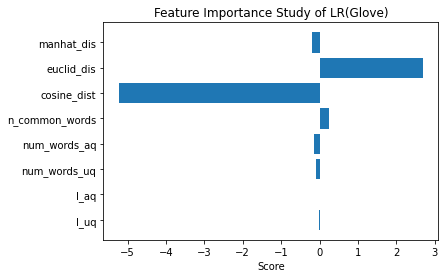

In [31]:
#get feature importance plot
feature_list = ['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_dist', 'euclid_dis','manhat_dis']
importance = clf.coef_[0]
for i,v in zip(feature_list,importance):
    print('Feature: ',i, ', Score: %.5f' % v)
# plot feature importance
plt.barh(feature_list, importance)
plt.xlabel("Score")
plt.title("Feature Importance Study of LR(Glove)")
plt.show()

In [32]:
#finding mean reciprocal rank:
test_df_ml = pd.read_csv('test.csv') #getting the test data
test_df_ml.columns

Index(['Unnamed: 0', 'guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans',
       'is_duplicate', 'is_correspond', 'is_useful', 'f_uq', 'f_aq', 'l_uq',
       'l_aq', 'num_words_uq', 'num_words_aq', 'n_common_words',
       'total_word_count', 'fraction_common_words'],
      dtype='object')

In [33]:
test_df_ml = test_df_ml[['guid', 'qu_id', 'qu', 'qa_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
test_df_ml = test_df_ml[:500]
l = len(test_df_ml['qa'])#Number of archived Questions
print("Number of archived Questions:",l)

Number of archived Questions: 500


In [34]:
user_questions = test_df_ml['qu'].tolist()
LR_G_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l #appending user question to all archived questions dataframe
    test_ml['l_uq'] = test_ml['qu'].str.len()
    test_ml['l_aq'] = test_ml['qa'].str.len()
    test_ml['num_words_uq'] = test_ml['qu'].apply(lambda x: len(x.split(" ")))
    test_ml['num_words_aq'] = test_ml['qa'].apply(lambda x: len(x.split(" ")))
    test_ml['n_common_words'] = test_ml.apply(find_word_Common, axis=1)
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_dist'] = [cosine_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_ml['euclid_dis']  = [euclidean_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_ml['manhat_dis'] = [manhattan_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_x_data = test_ml[['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_dist', 'euclid_dis','manhat_dis']].copy()
    test_x_data = test_x_data.values
    y_pred = clf.predict_proba(test_x_data) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        LR_G_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        LR_G_reciprocal_rank_list.append(0)


In [35]:
LR_G_mean_reciprocal_rank = np.mean(np.array(LR_G_reciprocal_rank_list))
print("Mean Reciprocal Rank for Logistic regression+Basic features+Glove ",LR_G_mean_reciprocal_rank)
print("Number of question correctly retreived for Logistic regression+Basic features+Glove: ", sum(LR_G_reciprocal_rank_list) )

Mean Reciprocal Rank for Logistic regression+Basic features+Glove  0.796
Number of question correctly retreived for Logistic regression+Basic features+Glove:  398


# Naive Bayes +Basic Features+Glove

In [36]:
#fitting with best params
nb = MultinomialNB(alpha = 100.0).fit(x_data,y_data)

Feature:  l_uq , Score: -1.06620
Feature:  l_aq , Score: -1.07267
Feature:  num_words_uq , Score: -2.65050
Feature:  num_words_aq , Score: -2.65675
Feature:  n_common_words , Score: -3.15166
Feature:  cosine_sim , Score: -7.33748
Feature:  euclid_dis , Score: -4.71610
Feature:  manhat_dis , Score: -2.11679


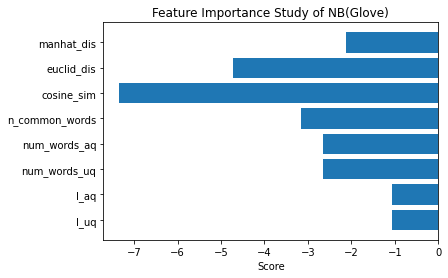

In [44]:
#get feature importance plot
feature_list = ['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_sim', 'euclid_dis','manhat_dis']
importance = nb.coef_[0]
for i,v in zip(feature_list,importance):
    print('Feature: ',i, ', Score: %.5f' % v)
# plot feature importance
plt.barh(feature_list, importance)
plt.xlabel("Score")
plt.title("Feature Importance Study of NB(Glove)")
plt.show()

In [38]:
user_questions = test_df_ml['qu'].tolist()
NB_G_reciprocal_rank_list = []
most_similar_quest_id = 0
arch_questions = test_df_ml['qa'].tolist()
for uquest_id, user_quest in enumerate(user_questions):
    test_ml = test_df_ml[['guid', 'qu_id', 'qa', 'ans_id', 'ans','is_duplicate', 'is_correspond', 'is_useful',]].copy()
    test_ml.loc[:,'qu'] = [user_quest]*l
    test_ml['l_uq'] = test_ml['qu'].str.len()
    test_ml['l_aq'] = test_ml['qa'].str.len()
    test_ml['num_words_uq'] = test_ml['qu'].apply(lambda x: len(x.split(" ")))
    test_ml['num_words_aq'] = test_ml['qa'].apply(lambda x: len(x.split(" ")))
    test_ml['n_common_words'] = test_ml.apply(find_word_Common, axis=1)
    #finding distances
    ml_test_user_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qu'].tolist()])
    ml_test_arch_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_ml['qa'].tolist()])
    test_ml['cosine_sim'] = [cosine_similarity(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)] #getting cosine similarity between pir of questions and saving it in all_text dataframe
    test_ml['euclid_dis']  = [euclidean_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_ml['manhat_dis'] = [manhattan_distances(user_quest,arch_quest)[0][0] for user_quest,arch_quest in zip(ml_test_user_vecs,ml_test_arch_vecs)]
    test_x_data = test_ml[['l_uq','l_aq','num_words_uq','num_words_aq', 'n_common_words','cosine_sim', 'euclid_dis','manhat_dis']].copy()
    test_x_data = test_x_data.values
    y_pred = nb.predict_proba(test_x_data) #predict probability
    #print(max(x_data))
    y_max = y_pred[:,1] #selecting only probability of duplication
    #print(max(y_max))
    most_similar_quest_id = np.argmax(np.array(y_max))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        NB_G_reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        NB_G_reciprocal_rank_list.append(0)


In [39]:
NB_G_mean_reciprocal_rank_list = np.mean(np.array(NB_G_reciprocal_rank_list))
print("Mean Reciprocal Rank for Naive Bayes+Basic features_Glove ",NB_G_mean_reciprocal_rank_list)
print("Number of question correctly retreived for  Naive Bayes+Basic features_Glove: ", sum(NB_G_reciprocal_rank_list) )

Mean Reciprocal Rank for Naive Bayes+Basic features_Glove  0.7
Number of question correctly retreived for  Naive Bayes+Basic features_Glove:  350


In [42]:
results_df = pd.DataFrame()
results_df["Method"] = ["LR+BasicFeature+WV","NB+BasicFeature+WV","LR+BasicFeature+Glove","NB+BasicFeature+Glove"]
results_df["mean_reciprocal_ranks"] = [LR_WV_mean_reciprocal_rank,NB_WV__mean_reciprocal_rank,LR_G_mean_reciprocal_rank,NB_G_mean_reciprocal_rank_list]
results_df

,Method,mean_reciprocal_ranks
0,LR+BasicFeature+WV,0.770
1,NB+BasicFeature+WV,0.692
2,LR+BasicFeature+Glove,0.796
3,NB+BasicFeature+Glove,0.700


([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

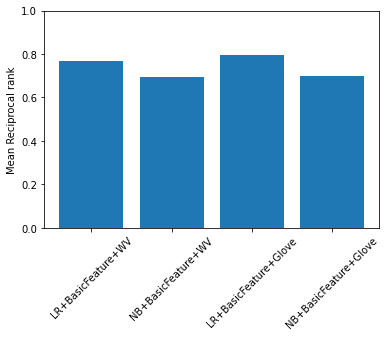

In [43]:
import matplotlib.pyplot as plt
plt.bar(results_df["Method"],results_df["mean_reciprocal_ranks"])
plt.ylabel("Mean Reciprocal rank")
plt.ylim(0,1)
plt.xticks(rotation = 45)